In [367]:
from importlib import reload
import qubic.job_manager_jpm as _jm
from matplotlib import pyplot as plt
import chipcalibration.rabi_experiments as _rabi
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as _cfg
import qubic.rpc_client as _rc
import numpy as np

In [368]:
reload(_jm)
reload(_rabi)

<module 'chipcalibration.rabi_experiments' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_experiments.py'>

In [369]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname)

In [370]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner)

# GMM Rabi

In [371]:
register = ['Q1', 'Q2']
target_amplitude = 0.4
pulse_width_interval = np.linspace(0, 100e-9, 10)

In [372]:
gmm_rabi = _rabi.GMMRabi(register, target_amplitude, pulse_width_interval, 
                       channel_configs=channel_config)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

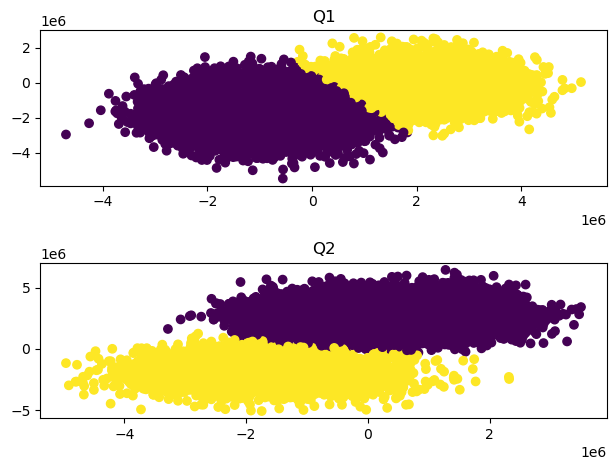

In [373]:
gmm_rabi.run_and_report(jm, 1000, qchip)

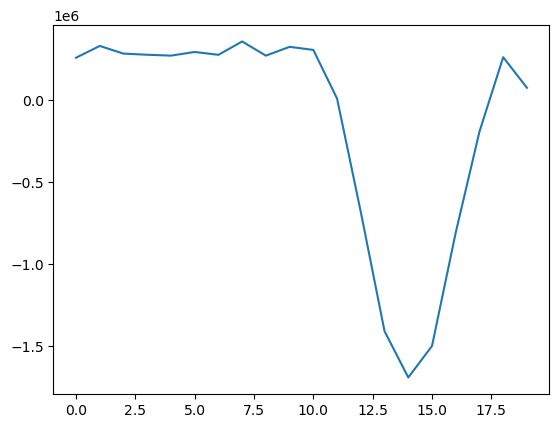

In [378]:
plt.plot(np.average(gmm_rabi.raw_iq_shots['1'].real, axis=1))

In [379]:
gmm_manager = gmm_rabi.gmm_manager

# Time Rabi

I'll target Q2, this time I'll use a jobmanager with a gmm manager 

In [456]:
reload(_rabi)

<module 'chipcalibration.rabi_experiments' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_experiments.py'>

In [457]:
register = ['Q1', 'Q2']
target_amplitude = 0.3
pulse_width_interval = np.linspace(0, 100e-9, 10)

In [458]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, gmm_manager)

In [459]:
trabi = _rabi.TimeRabi(['Q2'], ['Q1', 'Q2'], target_amplitude, 
                      pulse_width_interval)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

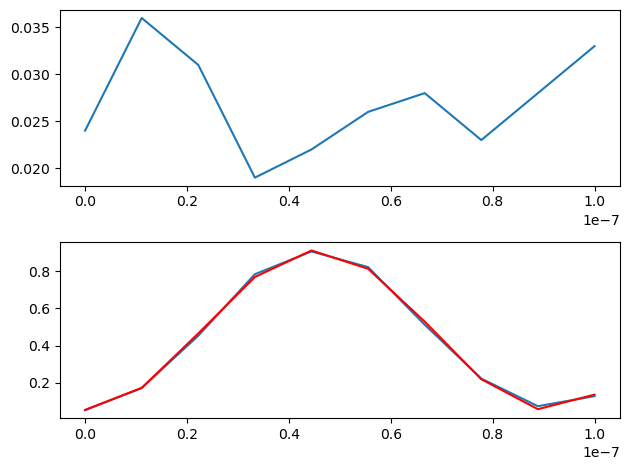

[2.2691893960609886e-08, 0.3]

In [460]:
trabi.run_and_report(jm, 1000, qchip, fit_type='period', period=90e-9)